In [11]:
import pandas as pd
import numpy as np
import random as rd
import seaborn as sbs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot
import time
import csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [12]:
file_data = 'DS_Agua_2017_2022_por_ponto.csv'
path_name='data/'
path_name_results='results/'
file_result = 'Result_SVR-MLP_Model_Hour.csv'

In [13]:
dataset = pd.read_csv(f'{path_name}{file_data}', sep =';', encoding = 'latin1', decimal='.')

In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368849 entries, 1 to 368849
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   DT_MEDICAO_HORA         368849 non-null  object 
 1   PRECIPITACAO            368849 non-null  float64
 2   PRESSAO_ATMOSFERICA     368849 non-null  float64
 3   TEMPERATURA_DO_AR_C     368849 non-null  float64
 4   UMIDADE_RELATIVA_DO_AR  368849 non-null  float64
 5   VELOCIDADE_VENTO        368849 non-null  float64
 6   SK_PONTO                368849 non-null  int64  
 7   VL_MEDICAO              368849 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 25.3+ MB


In [15]:
#verifica se existe variáveis nulas 
dataset.isna().sum()

DT_MEDICAO_HORA           0
PRECIPITACAO              0
PRESSAO_ATMOSFERICA       0
TEMPERATURA_DO_AR_C       0
UMIDADE_RELATIVA_DO_AR    0
VELOCIDADE_VENTO          0
SK_PONTO                  0
VL_MEDICAO                0
dtype: int64

In [16]:
def salvar_resultado(sk_ponto, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, Duration):
  #Script to write training cycle results
  data = [sk_ponto, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, Duration]
  fields = ['SK_PONTO','Best Params','N_Past_Vl','MSE','RMSE','MAE','MAPE','Duration']
  with open(f'{path_name_results}{file_result}', "a",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(data)  
  print(fields)
  print(data)
    
#Script to create the results file
def criar_arquivo_resultado():
  fields = ['SK_PONTO','Best Params','N_Past_Vl','MSE','RMSE','MAE','MAPE','Duration']
  with open(f'{path_name_results}{file_result}', "w",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(fields)   

In [17]:
def imprime_grafico(y_test, predict):
  #O gráfico abaixo mostra os valores reais em preto e os valores prditos em azul
  npredicts=1000
  pyplot.figure(figsize=(10,7)) 
  pyplot.scatter(np.arange(0,y_test.shape[0],1)[0:npredicts],np.array(y_test)[0:npredicts], color = 'black')
  pyplot.plot(np.arange(0,predict.shape[0],1)[0:npredicts], np.array(predict)[0:npredicts], color = 'blue', linewidth=2)
  pyplot.xlabel('n seq.')
  pyplot.ylabel('consumo l/h')
  pyplot.show()

In [18]:
def previsao_SVR(sk_ponto, dataset, n_time_steps):

    # dataframe tratament
  df = pd.DataFrame()
  df['VL_MEDICAO']=dataset['VL_MEDICAO']  

  # time serire transform - shit 1 step time

  for n_step in range(1,n_time_steps+1,1):
    df['vl-'+str(n_step)]=dataset['VL_MEDICAO'].shift(n_step)  
    
  df['tp-1']=dataset['TEMPERATURA_DO_AR_C']
  df['pr-1']=dataset['PRESSAO_ATMOSFERICA']
  df['vv-1']=dataset['VELOCIDADE_VENTO']
  df['ur-1']=dataset['UMIDADE_RELATIVA_DO_AR']
  df['ch-1']=dataset['PRECIPITACAO']  

  df.dropna(inplace=True)
  
  
  
  #Split dataset in treinam /  75% treinam  25% test
  nlinhas = int(np.round(df.shape[0] *0.75)) # 
  
  max_size_train_split = int(np.round(nlinhas / 5)) 
  max_size__test_split = int(np.round((df.shape[0] - nlinhas) / 5))
  size_split = 5
  X_train = df.iloc[0:nlinhas,1: 6 + n_time_steps]
  y_train = df.iloc[0:nlinhas,0].values

  X_test = df.iloc[nlinhas:dataset.shape[0],1: 6 + n_time_steps] 
  y_test = df.iloc[nlinhas:dataset.shape[0],0].values
  
  
  # Stores the training execution start time
  Hora_Inicio = time.time()
  
  #Create SVR Regressor
  modelo  = SVR(kernel='rbf')
  
  # Validados cruzado para séries temporais para 5 conjuntos de dados
  ts_cv = TimeSeriesSplit(
      n_splits=size_split, # Number of divisions
      max_train_size=max_size_train_split,    # maximum size of each set. of training
      gap=2, # number of samples to exclude between each training and testing set
      test_size=max_size__test_split, # maximum size of each set. of test.
  )
  C = [ 12550, 125550, 1255555] # Parâmetro de regularização
  gamma = [ 0.00001, 0.000001, 0.0000001, 0.00000001] # Coeficiente da função kernel  
  epsilon = [0.1, 0.01, 0.001, 0.0001]

  hyper_params = [{'kernel': ['rbf'],'C': C, 'gamma':gamma, 'epsilon':epsilon}]  

  modelo = SVR(max_iter=500)
  grid = GridSearchCV(modelo,param_grid=hyper_params,verbose=20,n_jobs=-4,cv=ts_cv, scoring='neg_mean_absolute_percentage_error')
  grid.fit(np.array(X_train), np.array(y_train))
  
  resultado = str(grid.best_params_)
  

  predict=grid.predict(np.array(X_test))   
  
  #Estimate Et for treinam and test
  # For treinam data
  Lt_train = grid.predict(X_train)
  Yt_train = y_train
  Et_train = Yt_train - Lt_train  

  # For test data
  Lt_test = predict
  Yt_test = y_test
  Et_test = Yt_test - Lt_test  

  #create  dataframe of Et value
  df_Et = pd.DataFrame(Et_train, columns=['VL_Et'])  

  for n_step in range(1,n_time_steps+1,1):
      df_Et['vl-'+str(n_step)]=df_Et['VL_Et'].shift(n_step)    

  #drop rows with null values
  df_Et.dropna(inplace=True)  

  Nt_train = df_Et['VL_Et']  

  df_Et.drop(['VL_Et'],axis=1, inplace=True)  

  X_train = df_Et
  y_train = Nt_train
  
  # MLP model for hybrid prediction for non linear component Et_train 

  #Split dataset in treinam /  75% treinam  25% test
  nlinhas = int(np.round(X_train.shape[0] * 0.75)) # 
    
  max_size_train_split = int(np.round(nlinhas / 5)) 
  max_size__test_split = int(np.round((X_train.shape[0] - nlinhas) / 5))
  size_split = 5
    
  # Cross-validated for time series
  ts_cv_mlp = TimeSeriesSplit(
        n_splits=size_split, # Number of divisions
        max_train_size=max_size_train_split,    # maximum size of each set. of training
        gap=2, # number of samples to exclude between each training and testing set
        test_size=max_size__test_split, # maximum size of each set. of test.
  )  

  param_grid = {
       'hidden_layer_sizes': [(4,6,1),(2,6,1),(6,12,1),(6,18,1)], # MLP layers
       'max_iter': [ 500], # maximum iterations
       'activation': [ 'relu','identity'], # activation function
       'solver': ['adam'], # weight optimization algorithm
       'alpha': [0.0001, 0.001, 0.01],  # alpha strength of regularization
  }
    
  modelo = MLPRegressor(random_state=0)
    
  grid_mlp = GridSearchCV(modelo, param_grid, n_jobs= -1,scoring='neg_mean_absolute_percentage_error', cv=ts_cv_mlp, verbose=1)
  grid_mlp.fit(np.array(X_train), np.array(y_train))  

  resultado = 'SVR-MLP' + resultado +'-' + str(grid_mlp.best_params_)
  
  #MAPE to Et predicted on MLP Model
  predict=grid_mlp.predict(X_train)  
  # Recomposition of Nt + Lt form train data
  Lt_train2 = Lt_train[n_time_steps:len(Lt_train)]
  Yt_train2 = Yt_train[n_time_steps:len(Yt_train)]
  Yt_train_predicted = predict + Lt_train2
  ((np.mean(np.abs(Yt_train2 - Yt_train_predicted) / (Yt_train2)))) * 100
  
  # For test data
  #Lt_test = predict
  #Yt_test = y_test
  #Et_test = Yt_test - Lt_test
  
  
  #create  dataframe of Et value
  df_Et = pd.DataFrame(Et_test, columns=['VL_Et'])
  
  for n_step in range(1,n_time_steps+1,1):
      df_Et['vl-'+str(n_step)]=df_Et['VL_Et'].shift(n_step)  
  
  #drop rows with null values
  df_Et.dropna(inplace=True)
  
  Nt_test = df_Et['VL_Et']
  
  df_Et.drop(['VL_Et'],axis=1, inplace=True)
  
  X_test = df_Et
  y_test = Nt_test
  
  predict=grid_mlp.predict(X_test)  
  
  # Recomposition of Nt + Lt form test data
  Lt_test2 = Lt_test[n_time_steps:len(Lt_test)]
  Yt_test2 = Yt_test[n_time_steps:len(Yt_test)]
  Yt_test_predicted = predict + Lt_test2
  MAPE = ((np.mean(np.abs(Yt_test2 - Yt_test_predicted) / (Yt_test2)))) * 100
  print('MAPE',MAPE)
  
  predict = Yt_test_predicted
  y_test = Yt_test2
  
  # Stores the training execution end time
  Hora_Fim = time.time()   

  #Calculate the duration of the training execution
  Duracao = Hora_Fim - Hora_Inicio   

  #Mean Squared Error (Mean Squared Difference Between Estimated Values and Actual Values) - MSE
  MSE = mean_squared_error(y_test, predict)   

  # Square Root of Mean Error - RMSE
  RMSE = np.sqrt(mean_squared_error(y_test, predict))   

  # Mean Absolute Distance or Mean Absolute Error - MAE
  MAE= median_absolute_error(y_pred=predict, y_true = y_test)   

  #Calculate the MAPE (Mean Absolute Percentage Error)
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100    

  #O gráfico abaixo mostra os valores reais em preto e os valores prditos em azul
  #imprime_grafico(Yt_train2, Yt_train_predicted)

  salvar_resultado(sk_ponto, resultado, n_time_steps, MSE, RMSE, MAE, MAPE, Duracao)

forecast for sk_ponto =  5
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 6.558042368090268


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


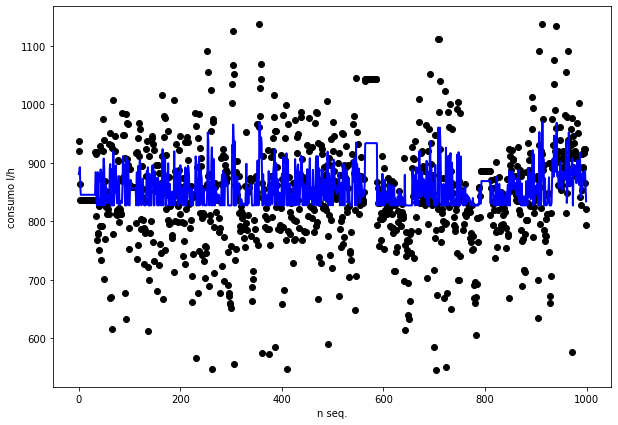

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[5, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 1, 5757.07984540534, 75.87542319753703, 44.48672222818209, 6.558042368090268, 204.30486178398132]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 8.179994992626439


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


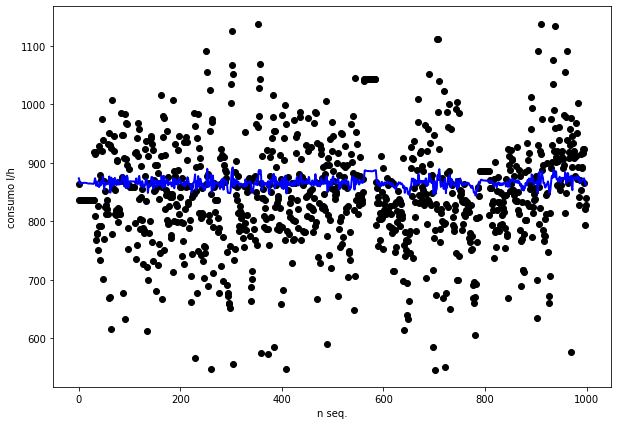

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[5, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 2, 8098.303748850401, 89.99057588909186, 60.6616623065878, 8.179994992626439, 242.66012048721313]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 6.146538659048819


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


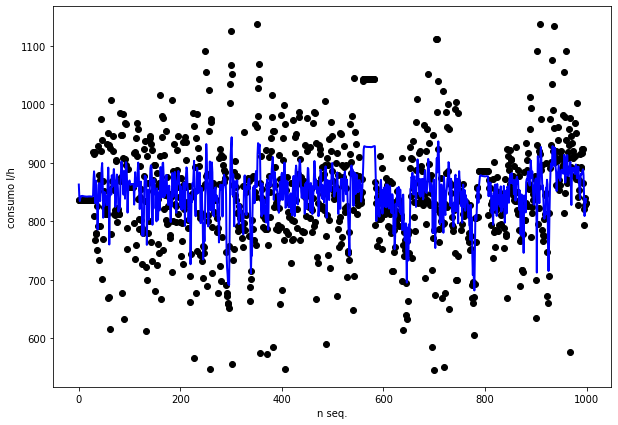

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[5, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 3, 5713.571648177824, 75.58817135093177, 37.71568504789553, 6.146538659048819, 241.40354204177856]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 6.181498975705312


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


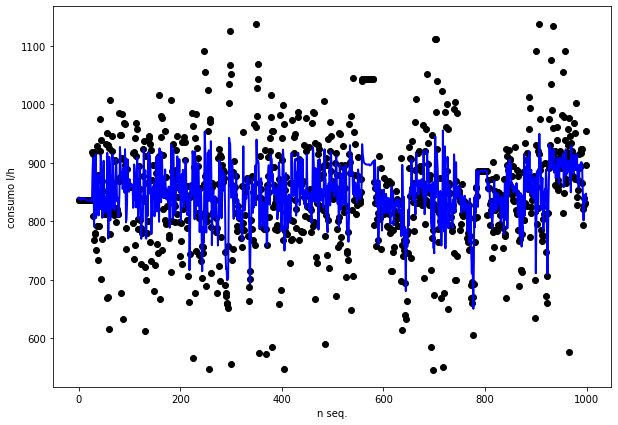

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[5, "{'C': 125550, 'epsilon': 0.0001, 'gamma': 1e-08, 'kernel': 'rbf'}", 4, 5918.832163489829, 76.93394675622608, 36.92762288207325, 6.181498975705312, 245.8334400653839]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 7.149305311125547


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


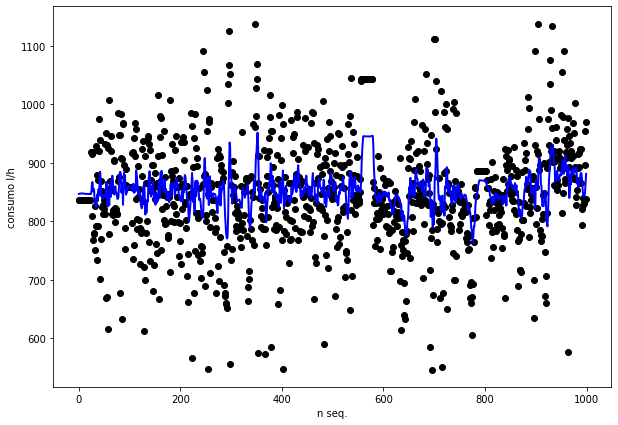

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[5, "{'C': 12550, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 5, 6695.631657613501, 81.82683946978217, 47.98926586245307, 7.149305311125547, 356.76949763298035]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 5.820877264578618


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


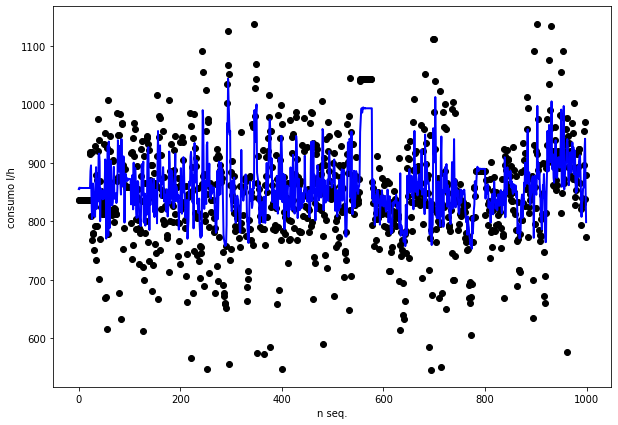

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[5, "{'C': 12550, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 6, 5043.586739810201, 71.01821414123422, 33.50591693766256, 5.820877264578618, 273.4350919723511]
forecast for sk_ponto =  6
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 46.2912705580136


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_18344\2190327962.py:128: RuntimeWarning: divide by zero encountered in true_divide
  ((np.mean(np.abs(Yt_train2 - Yt_train_predicted) / (Yt_train2)))) * 100
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


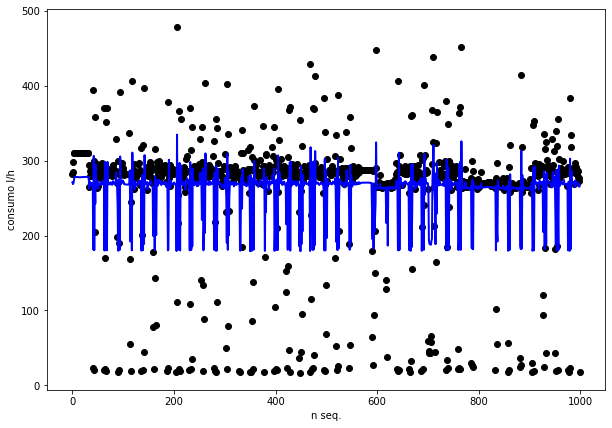

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[6, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 1, 5867.854170584004, 76.60192014945842, 67.26526546774272, 46.2912705580136, 254.04997849464417]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 44.14551791171701


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_18344\2190327962.py:128: RuntimeWarning: divide by zero encountered in true_divide
  ((np.mean(np.abs(Yt_train2 - Yt_train_predicted) / (Yt_train2)))) * 100
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


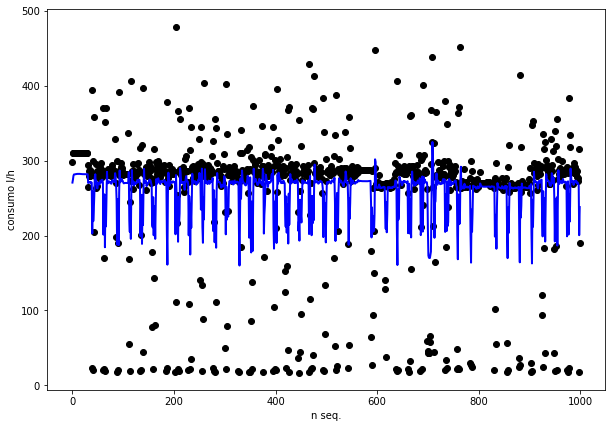

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[6, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 2, 5534.034616397222, 74.39109231888736, 60.0738518897781, 44.14551791171701, 258.3128674030304]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 35.50732229685275


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_18344\2190327962.py:128: RuntimeWarning: divide by zero encountered in true_divide
  ((np.mean(np.abs(Yt_train2 - Yt_train_predicted) / (Yt_train2)))) * 100
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


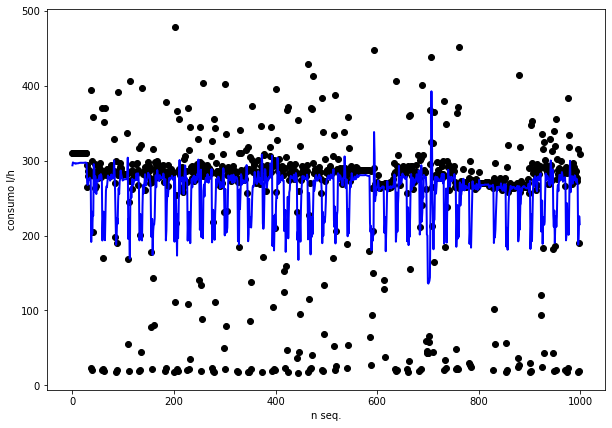

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[6, "{'C': 12550, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 3, 4258.181757738865, 65.2547450974936, 31.114088875344095, 35.50732229685275, 261.0085325241089]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 34.319761904130345


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_18344\2190327962.py:128: RuntimeWarning: divide by zero encountered in true_divide
  ((np.mean(np.abs(Yt_train2 - Yt_train_predicted) / (Yt_train2)))) * 100
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


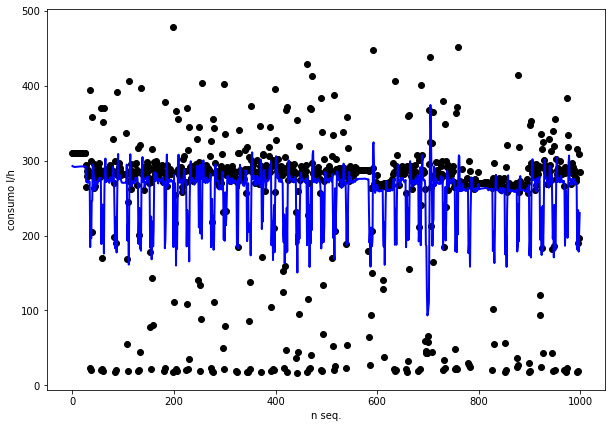

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[6, "{'C': 12550, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 4, 4417.042137599519, 66.46083160478447, 28.152254194342618, 34.319761904130345, 317.40271615982056]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 34.360453285989


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_18344\2190327962.py:128: RuntimeWarning: divide by zero encountered in true_divide
  ((np.mean(np.abs(Yt_train2 - Yt_train_predicted) / (Yt_train2)))) * 100
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


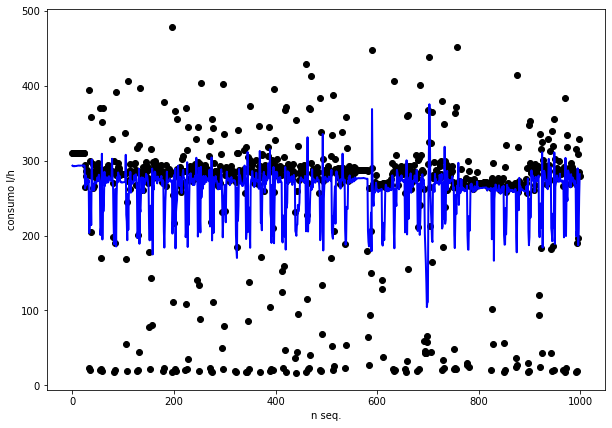

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[6, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 5, 4175.911454876231, 64.62129258128648, 28.343873050021898, 34.360453285989, 307.82041025161743]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 34.96306735823494


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_18344\2190327962.py:128: RuntimeWarning: divide by zero encountered in true_divide
  ((np.mean(np.abs(Yt_train2 - Yt_train_predicted) / (Yt_train2)))) * 100
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


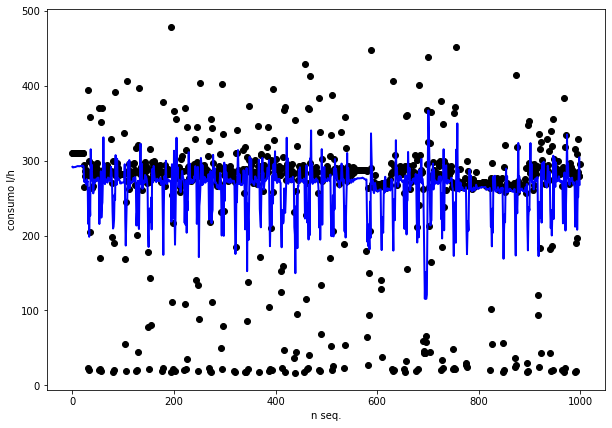

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[6, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 6, 4356.977327806793, 66.00740358328596, 30.922420415253214, 34.96306735823494, 332.1454870700836]
forecast for sk_ponto =  7
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 6.062010218128427


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


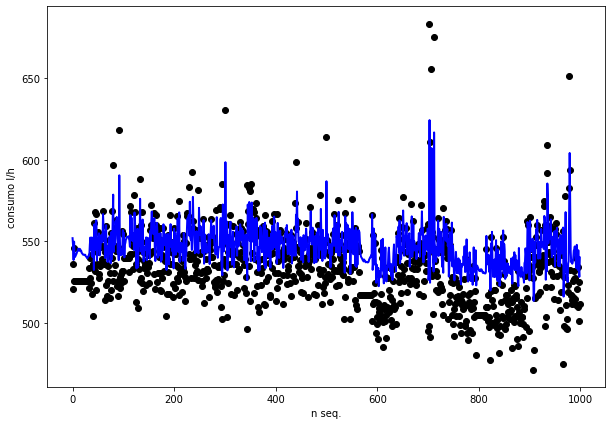

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[7, "{'C': 1255555, 'epsilon': 0.001, 'gamma': 1e-08, 'kernel': 'rbf'}", 1, 2090.758481060934, 45.724812531719955, 28.869993152996187, 6.062010218128427, 175.51779794692993]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 4.696052402967545


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


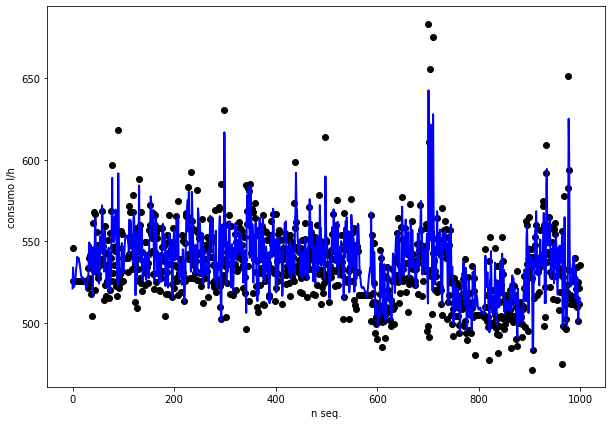

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[7, "{'C': 1255555, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 2, 1832.255394245748, 42.80485246144119, 16.699491676387083, 4.696052402967545, 214.59166479110718]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 5.878304950412232


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


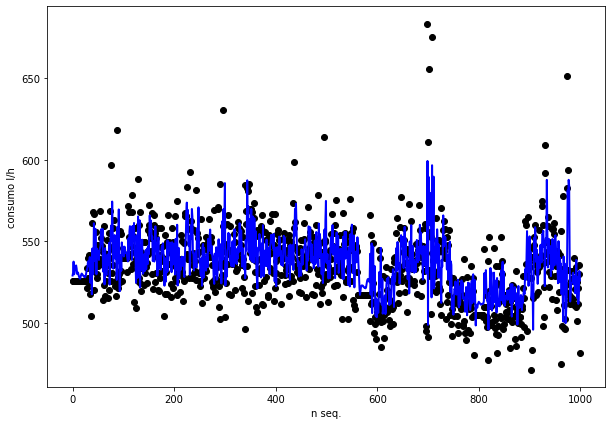

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[7, "{'C': 1255555, 'epsilon': 0.001, 'gamma': 1e-08, 'kernel': 'rbf'}", 3, 2333.9484597572227, 48.31095589777978, 23.763957700472133, 5.878304950412232, 225.229229927063]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 5.280560983307955


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


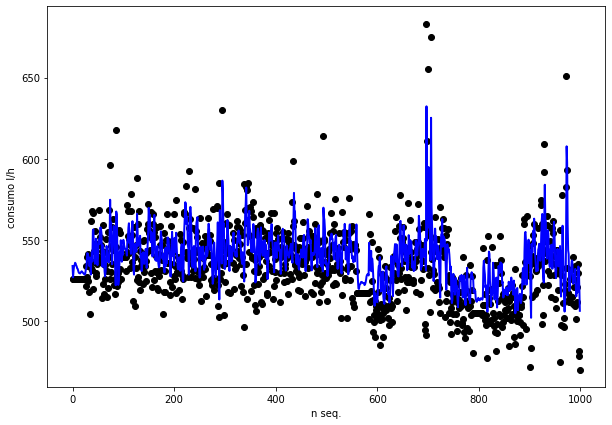

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[7, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'rbf'}", 4, 1875.466656701183, 43.30665834142809, 22.01232865825574, 5.280560983307955, 253.75122165679932]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 5.899467419517366


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


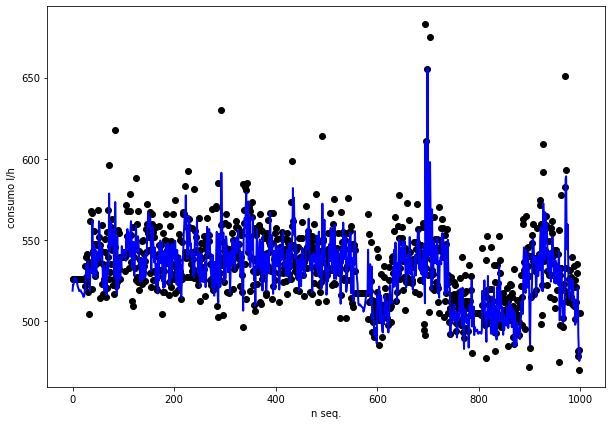

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[7, "{'C': 125550, 'epsilon': 0.001, 'gamma': 1e-08, 'kernel': 'rbf'}", 5, 2473.7207792072113, 49.736513540930986, 23.205405666983438, 5.899467419517366, 223.22085905075073]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 6.319724489491528


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


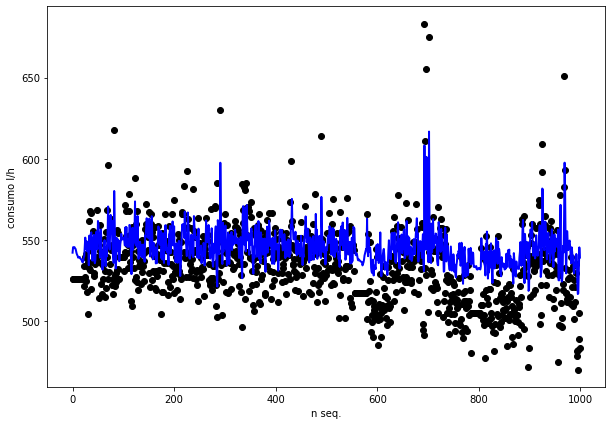

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[7, "{'C': 12550, 'epsilon': 0.001, 'gamma': 1e-07, 'kernel': 'rbf'}", 6, 2203.5734017261725, 46.94223473297977, 28.964762222993954, 6.319724489491528, 238.71743655204773]
forecast for sk_ponto =  11
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.640370874211141


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


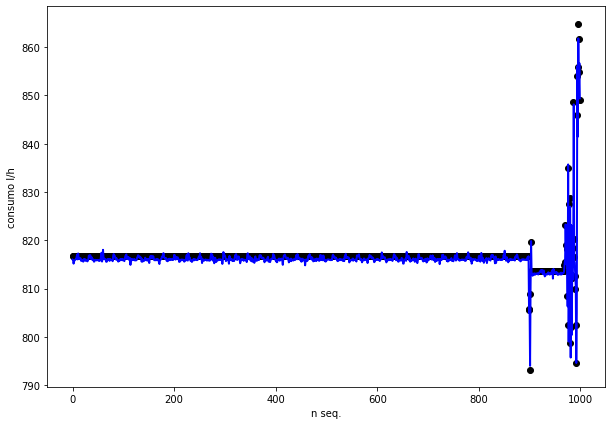

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[11, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 1, 441.3344444087014, 21.007961452951626, 9.634312345716125, 1.640370874211141, 247.0406584739685]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.82562864651437


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


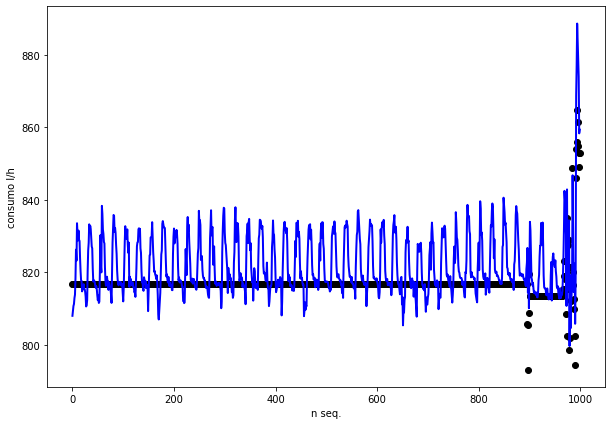

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[11, "{'C': 1255555, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 2, 546.8375210343075, 23.38455731961389, 10.348502481638889, 1.82562864651437, 197.36028838157654]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.5871284481894603


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


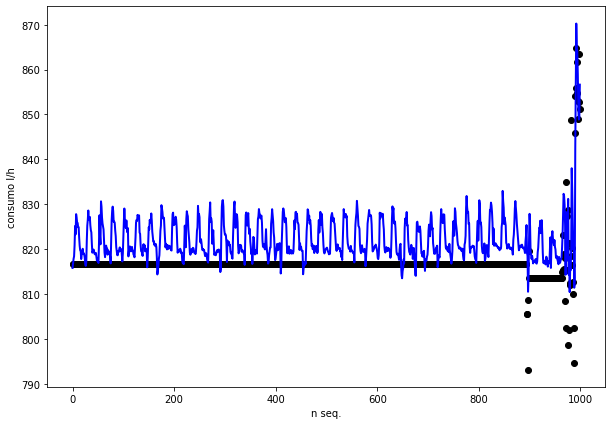

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[11, "{'C': 125550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 3, 437.42021791499, 20.91459341978682, 8.738254106482373, 1.5871284481894603, 180.61869549751282]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.5376452034623216


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


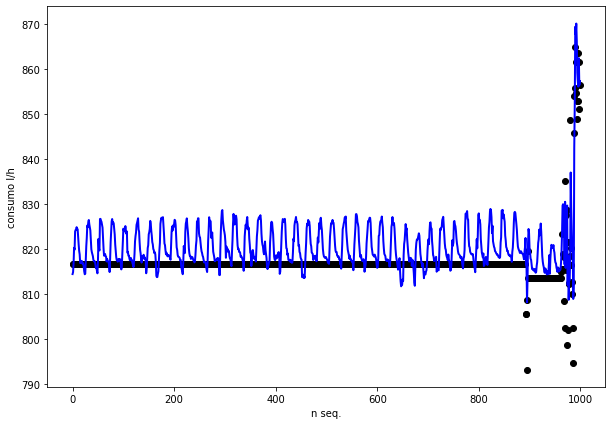

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[11, "{'C': 125550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 4, 450.27931203573206, 21.219785862155444, 7.715764190398602, 1.5376452034623216, 229.89868235588074]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.6460106670669636


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


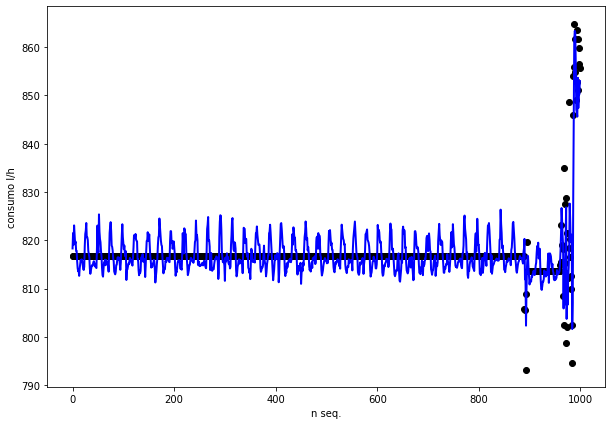

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[11, "{'C': 125550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 5, 461.38051004880737, 21.47976978574974, 9.02644956146446, 1.6460106670669636, 211.5651834011078]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.8202891265279524


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


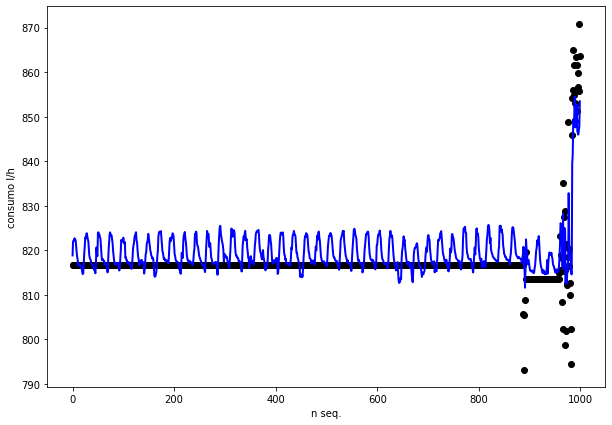

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[11, "{'C': 125550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 6, 493.60483816826724, 22.217219406763466, 10.738832870627732, 1.8202891265279524, 218.63842868804932]
forecast for sk_ponto =  12
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 8.31852097671387


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


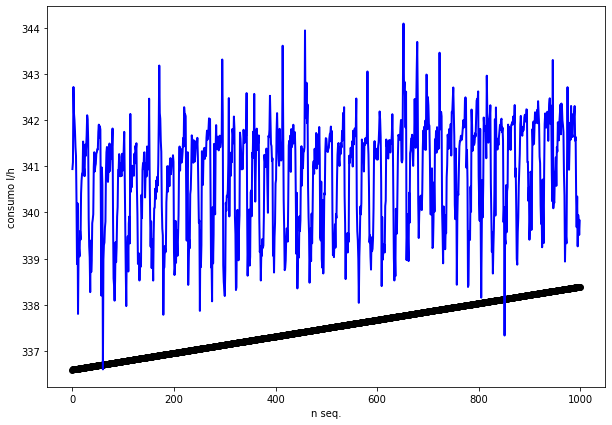

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[12, "{'C': 12550, 'epsilon': 0.001, 'gamma': 1e-07, 'kernel': 'rbf'}", 1, 1302.3510026913668, 36.08810056918162, 20.521355487364815, 8.31852097671387, 205.4194576740265]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 8.1264426308982


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


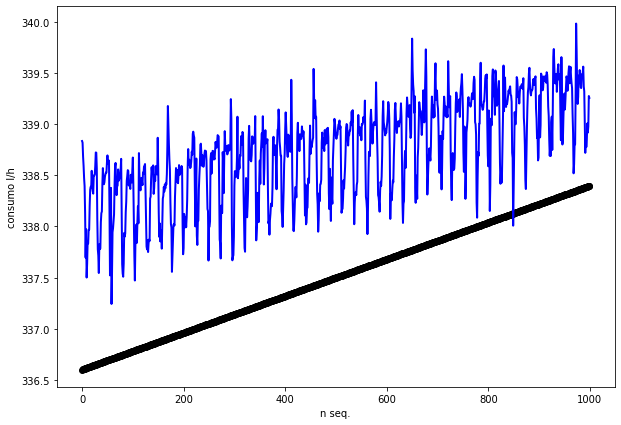

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[12, "{'C': 12550, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 2, 1279.3782400888758, 35.76839722560791, 19.191848980066425, 8.1264426308982, 236.63901114463806]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 8.161162243890985


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


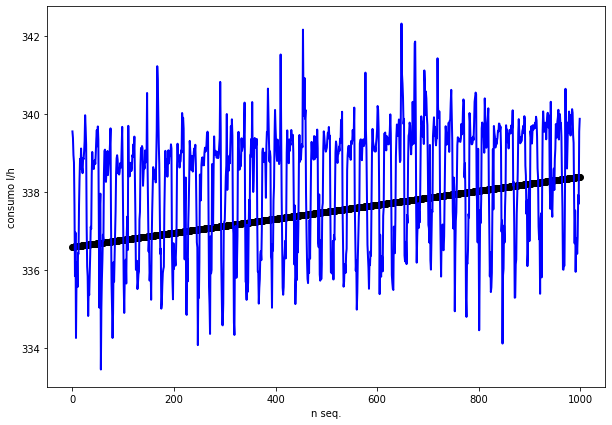

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[12, "{'C': 125550, 'epsilon': 0.001, 'gamma': 1e-08, 'kernel': 'rbf'}", 3, 1263.94938641611, 35.55206585300086, 19.574647108140937, 8.161162243890985, 247.21413564682007]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 8.111236806849055


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


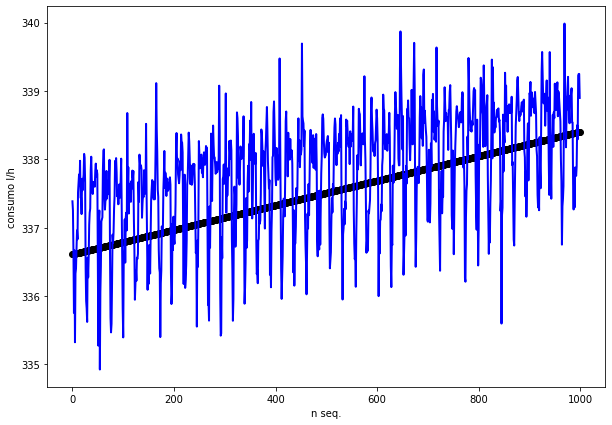

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[12, "{'C': 12550, 'epsilon': 0.0001, 'gamma': 1e-08, 'kernel': 'rbf'}", 4, 1313.089636750936, 36.23657871199951, 18.80535321252094, 8.111236806849055, 251.8842875957489]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 9.261789223266588


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


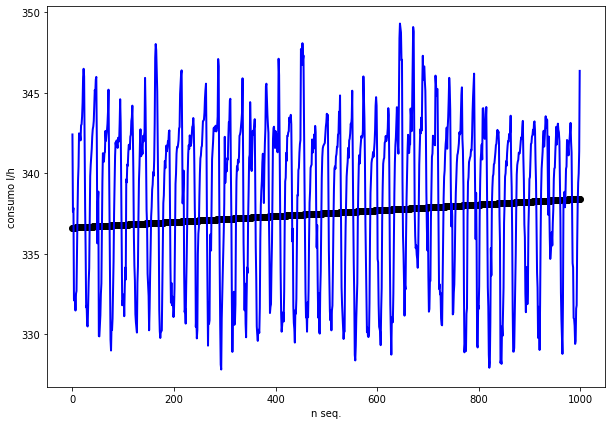

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[12, "{'C': 125550, 'epsilon': 0.0001, 'gamma': 1e-08, 'kernel': 'rbf'}", 5, 1423.922917543517, 37.73490317389879, 25.134092503127874, 9.261789223266588, 245.60799956321716]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 8.089405007386908


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


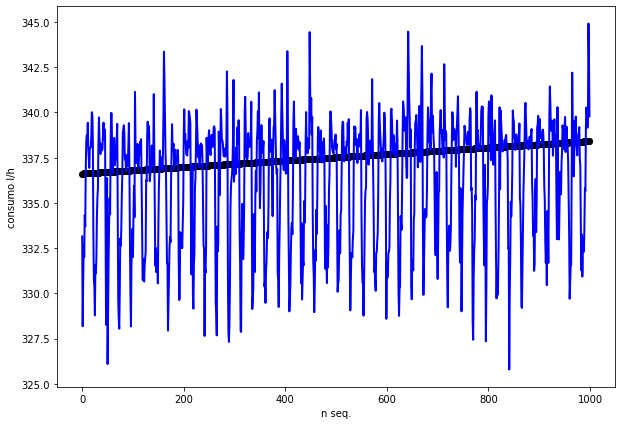

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[12, "{'C': 125550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 6, 1301.3168244737917, 36.07376920247996, 18.347770816326204, 8.089405007386908, 258.712171792984]
forecast for sk_ponto =  4
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 18.9470788682265


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


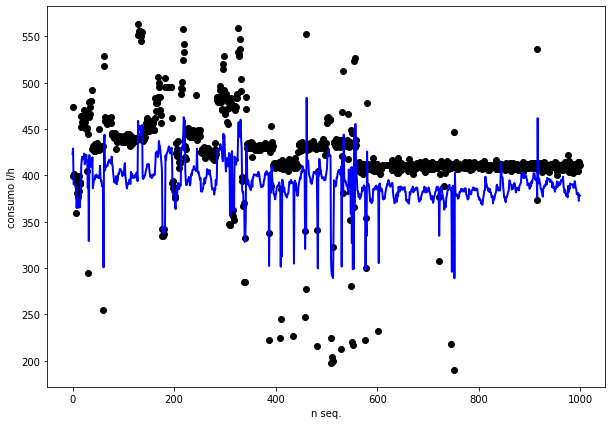

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[4, "{'C': 125550, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'rbf'}", 1, 15736.478199729536, 125.4451202706966, 108.02099690746479, 18.9470788682265, 202.37957549095154]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 14.853428758082782


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


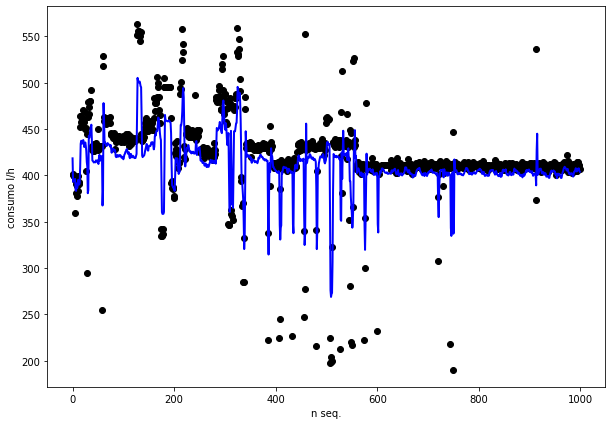

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[4, "{'C': 125550, 'epsilon': 0.0001, 'gamma': 1e-08, 'kernel': 'rbf'}", 2, 10582.383584041638, 102.87071295583422, 77.23518214871518, 14.853428758082782, 242.34129071235657]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


MAPE 14.315410962379177


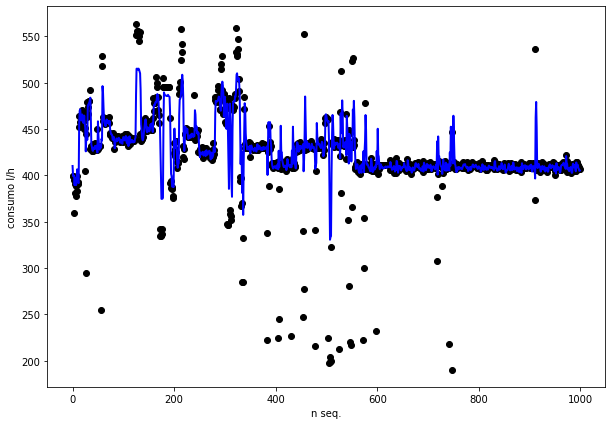

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[4, "{'C': 125550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 3, 9966.057549591866, 99.83014349179243, 76.93806782046886, 14.315410962379177, 292.0584557056427]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 11.961880723747301


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


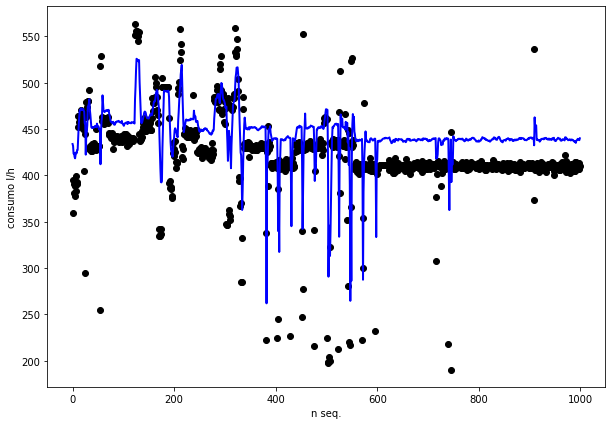

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[4, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 4, 7701.847897076242, 87.76017261307229, 56.27694112103484, 11.961880723747301, 298.5747013092041]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 18.58672183808729


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


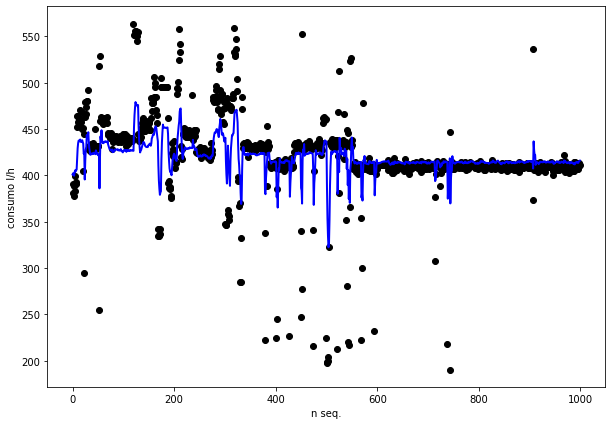

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[4, "{'C': 12550, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 5, 15508.235717465619, 124.5320670247853, 108.30810044261048, 18.58672183808729, 304.5234274864197]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 16.701277230374203


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


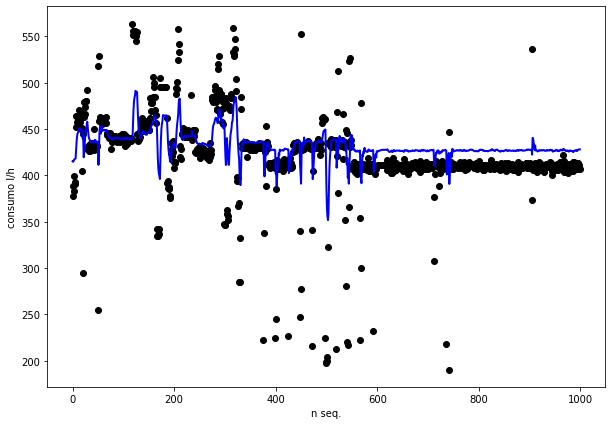

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[4, "{'C': 12550, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 6, 13053.716801421286, 114.25286342766769, 95.59295348362599, 16.701277230374203, 319.5418860912323]
forecast for sk_ponto =  13
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 5.826520195303208


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


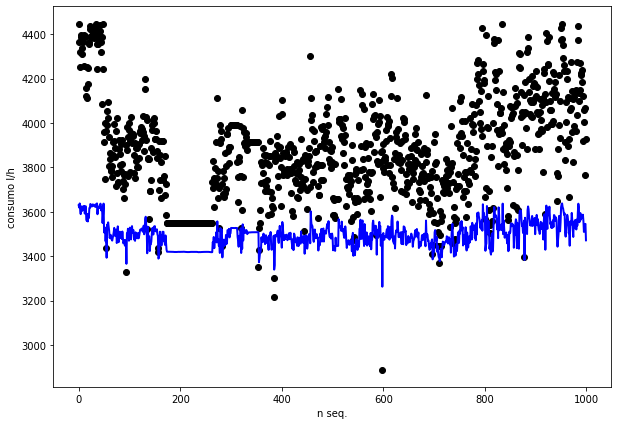

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[13, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 1, 60972.998592538985, 246.92711190255918, 157.04164385679042, 5.826520195303208, 227.18644881248474]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 5.143126245795745


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


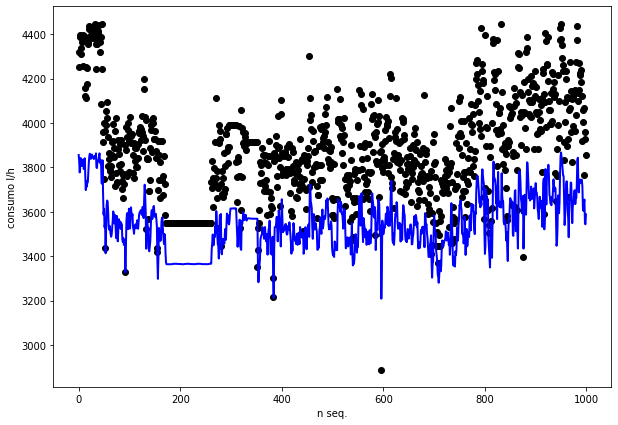

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[13, "{'C': 12550, 'epsilon': 0.001, 'gamma': 1e-08, 'kernel': 'rbf'}", 2, 55951.685129414065, 236.54108549977965, 144.82910218630195, 5.143126245795745, 249.96507120132446]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 4.33489203368576


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


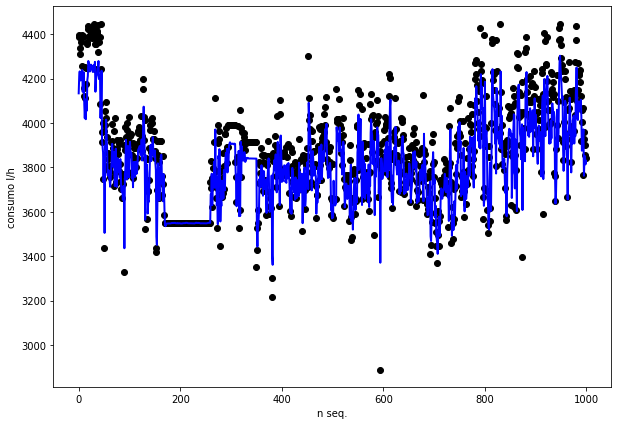

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[13, "{'C': 12550, 'epsilon': 0.001, 'gamma': 1e-08, 'kernel': 'rbf'}", 3, 46291.11307288109, 215.15369639604404, 88.1556706395445, 4.33489203368576, 252.0459430217743]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 7.184528078647895


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


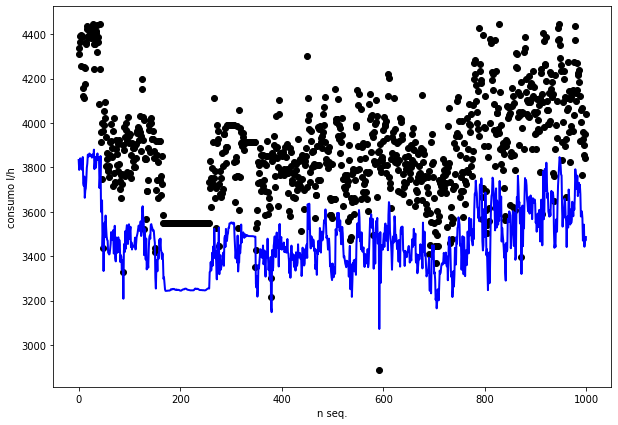

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[13, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 4, 93462.57143541805, 305.7164886547961, 233.22663853418317, 7.184528078647895, 278.5492718219757]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 8.155861580881536


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


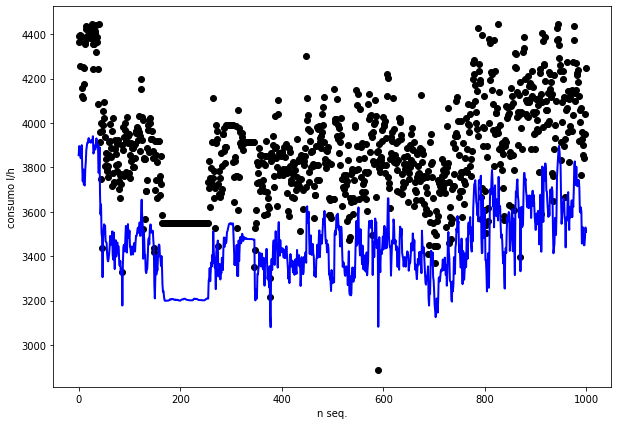

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[13, "{'C': 12550, 'epsilon': 0.0001, 'gamma': 1e-08, 'kernel': 'rbf'}", 5, 112337.80509846596, 335.1683235308283, 272.9555221350013, 8.155861580881536, 223.7681679725647]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 7.6409200631826995


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


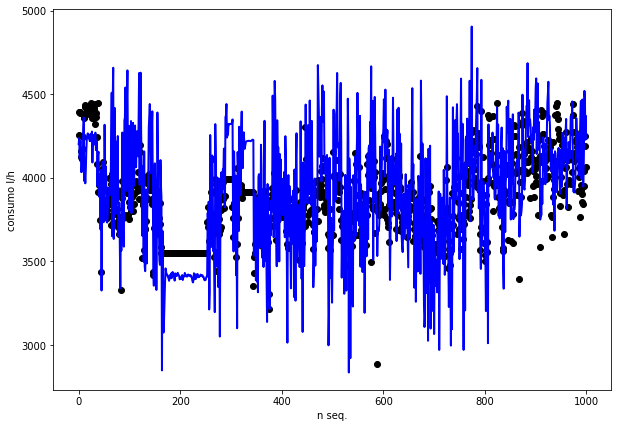

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[13, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}", 6, 106830.8174632748, 326.84983931964047, 199.54259724923895, 7.6409200631826995, 184.18494653701782]
forecast for sk_ponto =  8
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.950192617416507


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


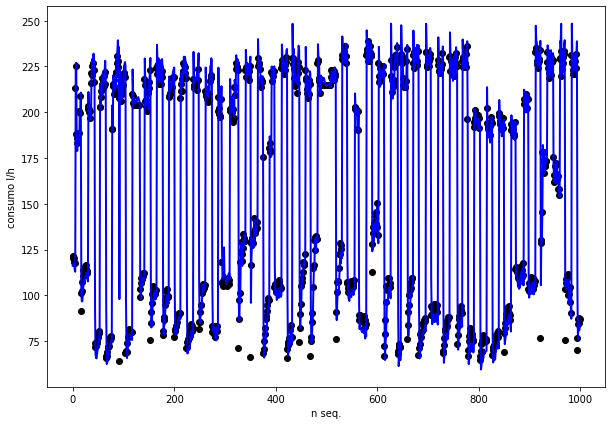

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[8, "{'C': 125550, 'epsilon': 0.01, 'gamma': 1e-07, 'kernel': 'rbf'}", 1, 38.633317016583504, 6.2155705302557305, 2.586771724728095, 1.950192617416507, 182.63234663009644]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.6280625911410056


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


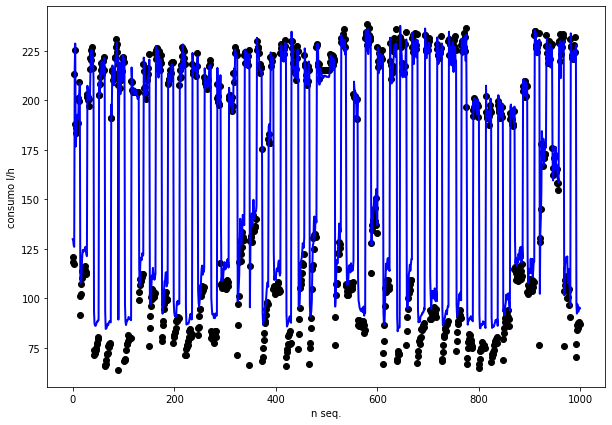

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[8, "{'C': 12550, 'epsilon': 0.01, 'gamma': 1e-07, 'kernel': 'rbf'}", 2, 29.310564594568298, 5.41392321653792, 2.067067654248504, 1.6280625911410056, 201.25286436080933]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.9834606154531365


c:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


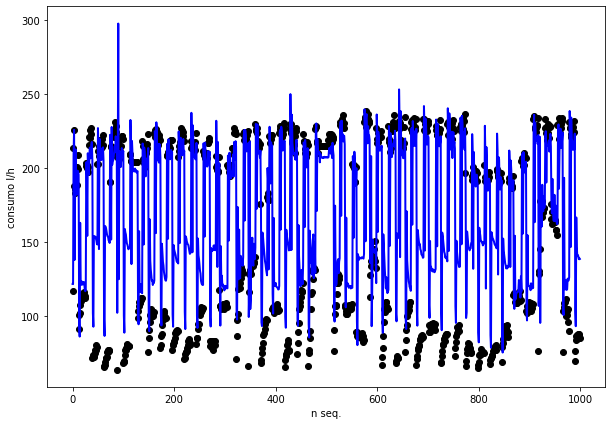

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[8, "{'C': 1255555, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 3, 41.96989722319453, 6.478417802457212, 2.4174933471510656, 1.9834606154531365, 240.49595308303833]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


MAPE 1.498479886456695


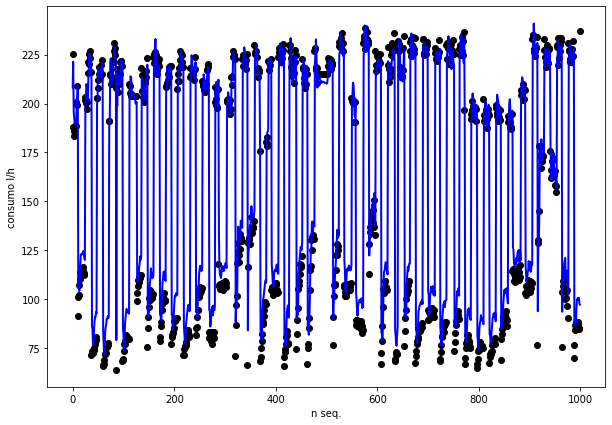

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[8, "{'C': 12550, 'epsilon': 0.01, 'gamma': 1e-07, 'kernel': 'rbf'}", 4, 28.06596055055061, 5.297731641990807, 1.8478446397611208, 1.498479886456695, 325.01469254493713]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


MAPE 1.3338000657684195


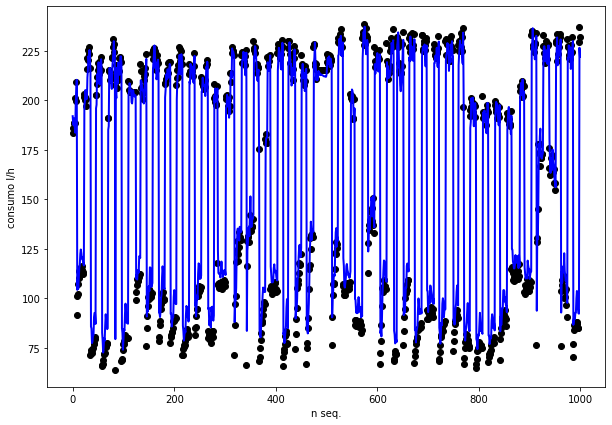

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[8, "{'C': 125550, 'epsilon': 0.001, 'gamma': 1e-08, 'kernel': 'rbf'}", 5, 26.38115436181493, 5.136258790385754, 1.5712600600911202, 1.3338000657684195, 463.75954008102417]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


MAPE 1.6905205141759552


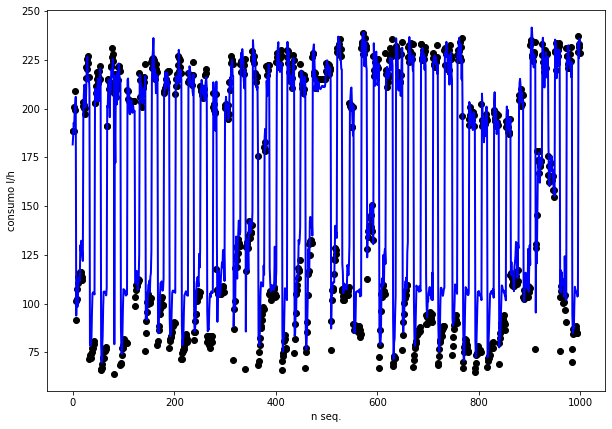

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[8, "{'C': 12550, 'epsilon': 0.001, 'gamma': 1e-07, 'kernel': 'rbf'}", 6, 32.08001300146785, 5.663922051146877, 2.1550087709384798, 1.6905205141759552, 378.246365070343]
forecast for sk_ponto =  1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


MAPE 3.886651975320394


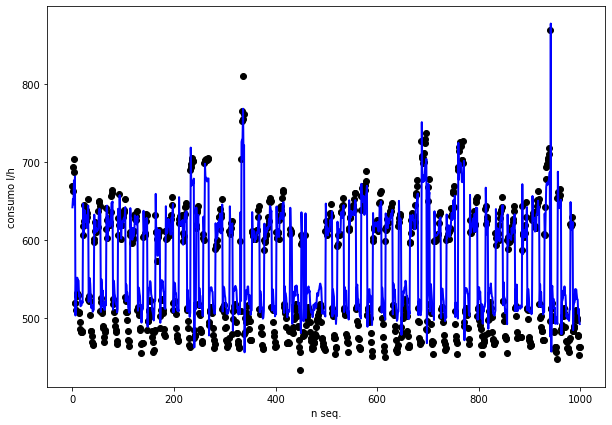

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[1, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'rbf'}", 1, 1934.1041147744465, 43.97845057268897, 11.838788829971463, 3.886651975320394, 258.07554268836975]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


MAPE 3.373125247072463


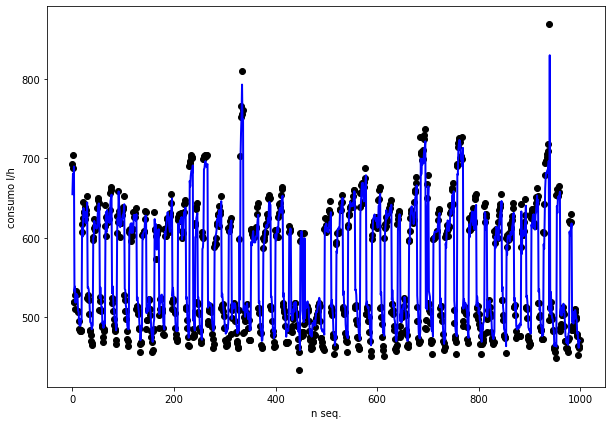

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[1, "{'C': 125550, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 2, 1835.17965747452, 42.83899692423388, 9.915152433426215, 3.373125247072463, 299.415673494339]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


MAPE 3.748995157277022


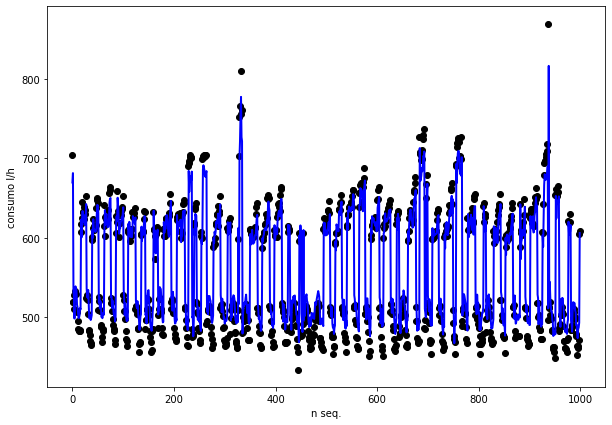

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[1, "{'C': 125550, 'epsilon': 0.001, 'gamma': 1e-08, 'kernel': 'rbf'}", 3, 1851.6070826735913, 43.030304236358724, 12.73442645063659, 3.748995157277022, 283.5713529586792]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 3.5571424910184337


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


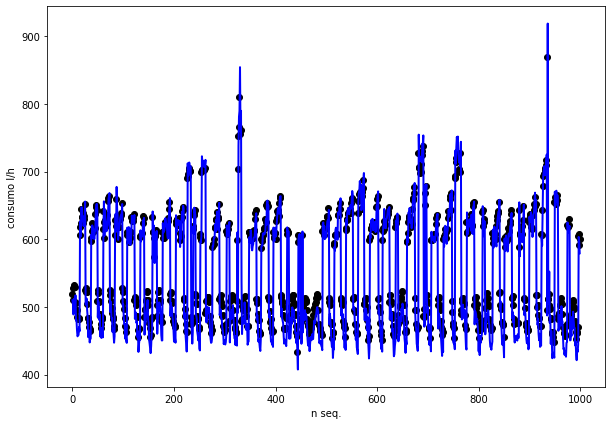

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[1, "{'C': 125550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 4, 2348.944742730133, 48.46591320433499, 8.898975815157769, 3.5571424910184337, 268.7465555667877]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 3.316332120372148


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


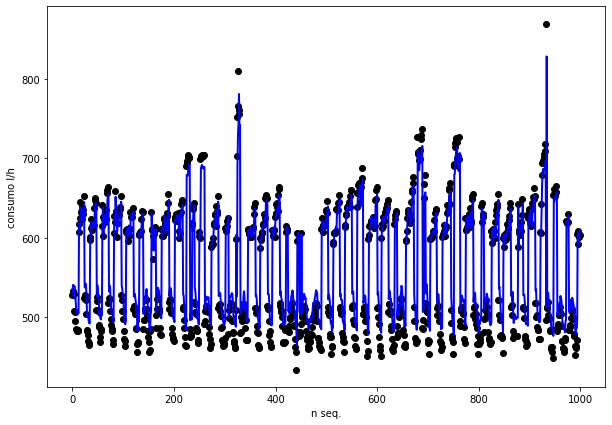

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[1, "{'C': 12550, 'epsilon': 0.0001, 'gamma': 1e-08, 'kernel': 'rbf'}", 5, 1798.4339197805948, 42.40794642258211, 8.810012601207688, 3.316332120372148, 176.60410976409912]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 3.3900683824149422


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


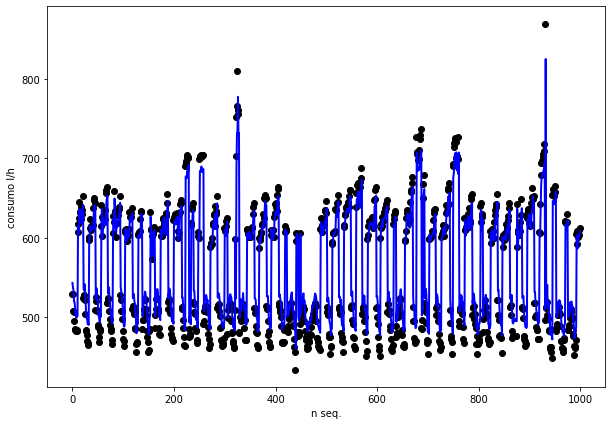

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[1, "{'C': 12550, 'epsilon': 0.0001, 'gamma': 1e-08, 'kernel': 'rbf'}", 6, 1820.3156033043215, 42.66515678284004, 9.604670252722087, 3.3900683824149422, 167.55541968345642]
forecast for sk_ponto =  9
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 0.9454663112533225


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


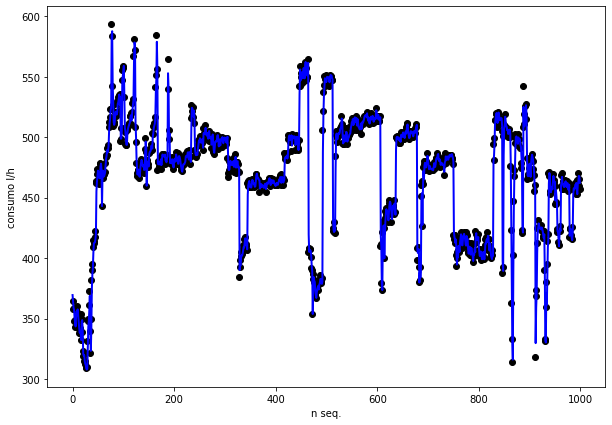

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[9, "{'C': 125550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 1, 68.81600359345653, 8.295541187496843, 2.8107618335117763, 0.9454663112533225, 102.57062673568726]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.740183286341811


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


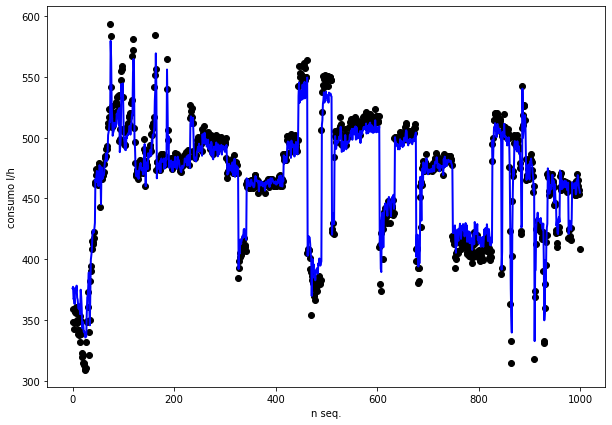

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[9, "{'C': 125550, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 2, 120.502186298136, 10.977348782749685, 5.526754921904143, 1.740183286341811, 115.45948934555054]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.2046839515625258


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


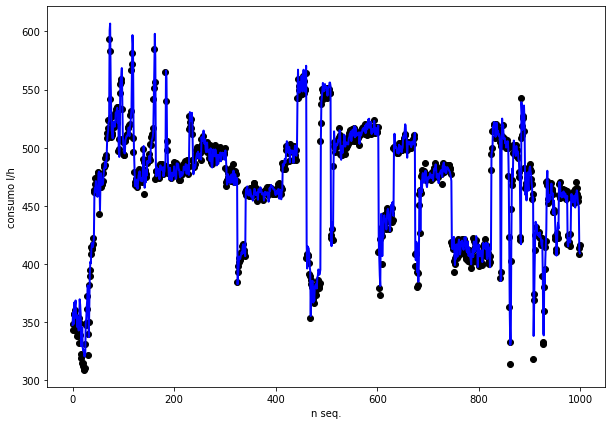

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[9, "{'C': 1255555, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 3, 83.35550576296863, 9.129923644969253, 3.8195239218028405, 1.2046839515625258, 114.28809595108032]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.1799401640624916


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


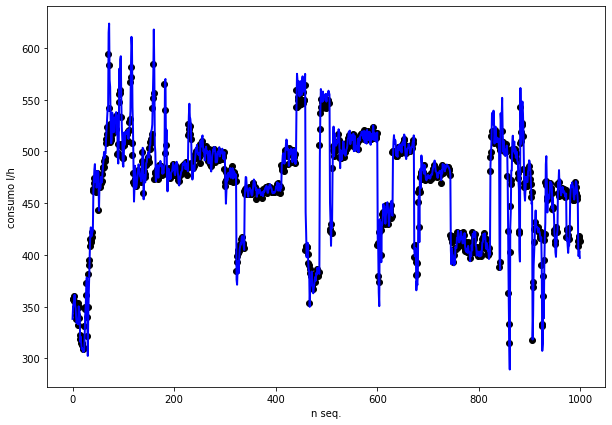

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[9, "{'C': 1255555, 'epsilon': 0.01, 'gamma': 1e-08, 'kernel': 'rbf'}", 4, 94.27827267423052, 9.709699927095096, 3.5847565558318593, 1.1799401640624916, 115.31238222122192]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.0212165938318334


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


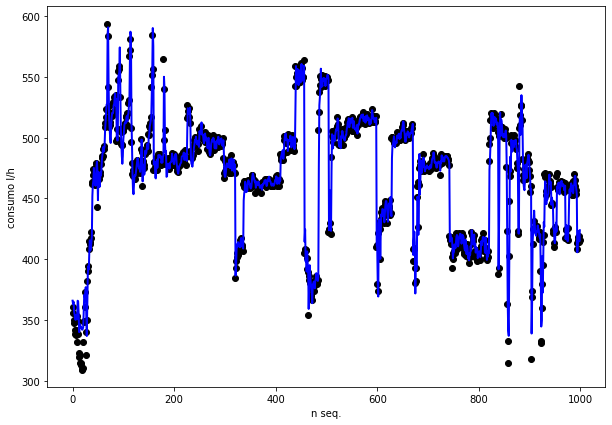

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[9, "{'C': 12550, 'epsilon': 0.0001, 'gamma': 1e-07, 'kernel': 'rbf'}", 5, 70.4706729624458, 8.394681230543885, 3.0272338816184288, 1.0212165938318334, 118.19011735916138]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Python\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits
MAPE 1.2463593224719975


c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
c:\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


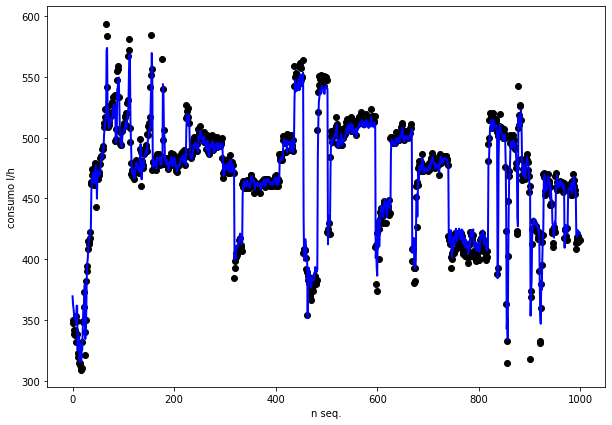

['SK_PONTO', 'Best Params', 'N_Past_Vl', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Duration']
[9, "{'C': 12550, 'epsilon': 0.1, 'gamma': 1e-08, 'kernel': 'rbf'}", 6, 82.18667027166637, 9.06568642032507, 3.8581237754507924, 1.2463593224719975, 130.42389678955078]


In [19]:
#selects the identification points of each reservoir
df_unique_pontos = dataset['SK_PONTO'].unique()

#create file to results
criar_arquivo_resultado()

for sk in np.array(df_unique_pontos):
    print('forecast for sk_ponto = ',sk)
    df_ponto = dataset[dataset['SK_PONTO']==sk]
    df_ponto = df_ponto.drop('SK_PONTO',axis=1)
    for n_time_steps in range(1,7): #predict with 1 to 6 past values of medition
        previsao_SVR(sk, df_ponto, n_time_steps)